<a href="https://colab.research.google.com/github/anjalii-s/Thesis-2026-/blob/main/Taiwan_dataset_experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ============================================================
# PART 1: Setup & Data Loading
# ============================================================

!pip install kagglehub imbalanced-learn shap lightgbm xgboost seaborn scikit-learn pandas numpy matplotlib tqdm -q

import os
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

# Set random seeds for reproducibility
np.random.seed(42)
plt.style.use('default')
sns.set_palette("husl")

# Load the dataset
import kagglehub
print("Downloading dataset...")
path = kagglehub.dataset_download("uciml/default-of-credit-card-clients-dataset")
csv_path = os.path.join(path, "UCI_Credit_Card.csv")
df = pd.read_csv(csv_path)

print(f"Dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print(f"Target distribution:\n{df['default.payment.next.month'].value_counts(normalize=True)}")

# Save a backup of the original data
df_original = df.copy()

Using Colab cache for faster access to the 'default-of-credit-card-clients-dataset' dataset.
Dataset shape: (30000, 25)
Columns: ['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'default.payment.next.month']
Target distribution:
default.payment.next.month
0    0.7788
1    0.2212
Name: proportion, dtype: float64


Data preprocessing

In [2]:
# ============================================================
# PART 2: Data Preprocessing
# ============================================================

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

def preprocess_data(df, target_col="default.payment.next.month", test_size=0.25, seed=42):
    """
    Preprocess the dataset: clean, encode, scale, and split
    """
    # Make a copy to avoid modifying original
    df = df.copy()

    # Drop ID column if present
    if "ID" in df.columns:
        df = df.drop(columns=["ID"])

    # Separate features and target
    y = df[target_col].astype(int)
    X = df.drop(columns=[target_col])

    # Define categorical and numerical columns
    cat_cols = ["SEX", "EDUCATION", "MARRIAGE"]
    num_cols = [c for c in X.columns if c not in cat_cols]

    print(f"Categorical columns: {cat_cols}")
    print(f"Numerical columns: {len(num_cols)} features")
    print(f"Target classes: {np.unique(y)}")

    # Create preprocessing transformer
    preprocessor = ColumnTransformer([
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), cat_cols),
        ("num", StandardScaler(), num_cols)
    ])

    # Fit preprocessor
    preprocessor.fit(X)
    feature_names = preprocessor.get_feature_names_out()
    print(f"Total features after encoding: {len(feature_names)}")

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=seed
    )

    return {
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test,
        'preprocessor': preprocessor,
        'feature_names': feature_names,
        'cat_cols': cat_cols,
        'num_cols': num_cols
    }

# Test the preprocessing
print("\nTesting preprocessing...")
preprocessed_data = preprocess_data(df_original)
print("Preprocessing completed successfully!")


Testing preprocessing...
Categorical columns: ['SEX', 'EDUCATION', 'MARRIAGE']
Numerical columns: 20 features
Target classes: [0 1]
Total features after encoding: 30
Preprocessing completed successfully!


Model and resampling

In [3]:
# ============================================================
# PART 3: Model and Resampling Definitions
# ============================================================

from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

def get_models():
    """Define the machine learning models"""
    models = {
        'RF': RandomForestClassifier(
            n_estimators=100,
            max_depth=10,
            random_state=42,
            n_jobs=-1
        ),
        'XGB': xgb.XGBClassifier(
            n_estimators=100,
            max_depth=6,
            random_state=42,
            eval_metric='logloss',
            n_jobs=-1
        ),
        'LGB': lgb.LGBMClassifier(
            n_estimators=100,
            max_depth=6,
            random_state=42,
            verbose=-1,
            n_jobs=-1
        )
    }
    return models

def get_resamplers(y_train):
    """Define resampling strategies"""
    # Compute class weights for cost-sensitive learning
    classes = np.unique(y_train)
    weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
    class_weight_dict = {cls: w for cls, w in zip(classes, weights)}
    print(f"Class weights: {class_weight_dict}")

    resamplers = {
        'None': None,
        'SMOTE': SMOTE(random_state=42),
        'Borderline': BorderlineSMOTE(random_state=42),
        'ADASYN': ADASYN(random_state=42),
        'SMOTEENN': SMOTEENN(random_state=42),
        'SMOTETomek': SMOTETomek(random_state=42),
        'Under': RandomUnderSampler(random_state=42),
        'CostSensitive': 'cost'
    }

    return resamplers, class_weight_dict

# Test the functions
print("\nTesting model and resampler definitions...")
models = get_models()
resamplers, class_weight_dict = get_resamplers(preprocessed_data['y_train'])
print(f"Models: {list(models.keys())}")
print(f"Resamplers: {list(resamplers.keys())}")


Testing model and resampler definitions...
Class weights: {np.int64(0): np.float64(0.6420133538777607), np.int64(1): np.float64(2.2603978300180834)}
Models: ['RF', 'XGB', 'LGB']
Resamplers: ['None', 'SMOTE', 'Borderline', 'ADASYN', 'SMOTEENN', 'SMOTETomek', 'Under', 'CostSensitive']


Model training

In [4]:
# ============================================================
# PART 4: Model Training Function
# ============================================================

from sklearn.metrics import roc_auc_score

def train_model_with_resampling(model, model_name, sampler, sampler_name,
                               preprocessor, X_train, y_train, X_test, y_test,
                               class_weight_dict):
    """
    Train a model with specified resampling strategy
    """
    # Create pipeline steps
    steps = [('prep', preprocessor)]

    # Add resampler if specified
    if sampler and sampler_name != 'CostSensitive' and sampler_name != 'cost':
        steps.append(('samp', sampler))

    steps.append(('clf', model))

    # Create pipeline
    pipe = ImbPipeline(steps)

    # Handle cost-sensitive learning
    if sampler_name == 'CostSensitive':
        if model_name == 'RF':
            pipe.named_steps['clf'].set_params(class_weight=class_weight_dict)
        elif model_name == 'XGB':
            ratio = class_weight_dict[1] / class_weight_dict[0]
            pipe.named_steps['clf'].set_params(scale_pos_weight=ratio)
        elif model_name == 'LGB':
            pipe.named_steps['clf'].set_params(class_weight=class_weight_dict)

    # Train the model
    pipe.fit(X_train, y_train)

    # Make predictions
    y_pred_proba = pipe.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_pred_proba)

    return {
        'pipeline': pipe,
        'auc': auc,
        'model_name': model_name,
        'sampler_name': sampler_name
    }

def train_all_combinations(preprocessed_data, seeds=[42, 123, 456]):
    """
    Train all model and resampler combinations across multiple seeds
    """
    results = []
    X = preprocessed_data['X_train']  # We'll use the full training set for multiple splits

    for run_idx, seed in enumerate(seeds, 1):
        print(f"\n=== RUN {run_idx} (seed={seed}) ===")

        # Split data for this run
        X_train, X_test, y_train, y_test = train_test_split(
            preprocessed_data['X_train'],
            preprocessed_data['y_train'],
            test_size=0.25,
            stratify=preprocessed_data['y_train'],
            random_state=seed
        )

        # Get resamplers for this split
        current_resamplers, class_weight_dict = get_resamplers(y_train)

        # Train all combinations
        for model_name, model in get_models().items():
            # Create a fresh instance of the model for each run
            if model_name == 'RF':
                current_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=seed)
            elif model_name == 'XGB':
                current_model = xgb.XGBClassifier(n_estimators=100, max_depth=6, random_state=seed, eval_metric='logloss')
            elif model_name == 'LGB':
                current_model = lgb.LGBMClassifier(n_estimators=100, max_depth=6, random_state=seed, verbose=-1)

            for sampler_name, sampler in current_resamplers.items():
                try:
                    result = train_model_with_resampling(
                        model=current_model,
                        model_name=model_name,
                        sampler=sampler,
                        sampler_name=sampler_name,
                        preprocessor=preprocessed_data['preprocessor'],
                        X_train=X_train,
                        y_train=y_train,
                        X_test=X_test,
                        y_test=y_test,
                        class_weight_dict=class_weight_dict
                    )

                    results.append({
                        'run': run_idx,
                        'seed': seed,
                        'model': model_name,
                        'sampler': sampler_name,
                        'auc': result['auc'],
                        'pipeline': result['pipeline'],
                        'X_test': X_test,
                        'y_test': y_test
                    })

                    print(f"  {model_name}+{sampler_name:12} → AUC: {result['auc']:.4f}")

                except Exception as e:
                    print(f"  ERROR: {model_name}+{sampler_name} → {str(e)}")

    # Create results DataFrame
    results_df = pd.DataFrame(results)

    # Display summary
    print("\n" + "="*50)
    print("AUC Summary (mean by model+sampler):")
    print("="*50)
    summary = results_df.groupby(['model', 'sampler'])['auc'].agg(['mean', 'std', 'count']).round(4)
    print(summary)

    return results_df

# Run training
print("\nStarting model training...")
results_df = train_all_combinations(preprocessed_data)
print(f"\nTotal trained configurations: {len(results_df)}")


Starting model training...

=== RUN 1 (seed=42) ===
Class weights: {np.int64(0): np.float64(0.6420255668847968), np.int64(1): np.float64(2.260246450575944)}
  RF+None         → AUC: 0.7879
  RF+SMOTE        → AUC: 0.7808
  RF+Borderline   → AUC: 0.7796
  RF+ADASYN       → AUC: 0.7765
  RF+SMOTEENN     → AUC: 0.7799
  RF+SMOTETomek   → AUC: 0.7802
  RF+Under        → AUC: 0.7849
  RF+CostSensitive → AUC: 0.7831
  XGB+None         → AUC: 0.7601
  XGB+SMOTE        → AUC: 0.7558
  XGB+Borderline   → AUC: 0.7559
  XGB+ADASYN       → AUC: 0.7519
  XGB+SMOTEENN     → AUC: 0.7667
  XGB+SMOTETomek   → AUC: 0.7560
  XGB+Under        → AUC: 0.7566
  XGB+CostSensitive → AUC: 0.7554
  LGB+None         → AUC: 0.7816
  LGB+SMOTE        → AUC: 0.7694
  LGB+Borderline   → AUC: 0.7687
  LGB+ADASYN       → AUC: 0.7686
  LGB+SMOTEENN     → AUC: 0.7705
  LGB+SMOTETomek   → AUC: 0.7694
  LGB+Under        → AUC: 0.7784
  LGB+CostSensitive → AUC: 0.7807

=== RUN 2 (seed=123) ===
Class weights: {np.int64(0): 

shap explanations simplified

In [5]:
# ============================================================
# PART 5: SHAP Explanations (Simplified)
# ============================================================

import shap
from sklearn.inspection import permutation_importance

def compute_shap_values(pipe, X_sample, n_samples=100):
    """
    Compute SHAP values for a given pipeline
    """
    try:
        # Get classifier and preprocessed data
        clf = pipe.named_steps['clf']
        X_processed = pipe.named_steps['prep'].transform(X_sample)

        # Use TreeExplainer for tree-based models
        explainer = shap.TreeExplainer(clf)
        shap_values = explainer.shap_values(X_processed)

        # Handle different return formats
        if isinstance(shap_values, list):
            # Binary classification: shap_values[0] for class 0, shap_values[1] for class 1
            if len(shap_values) == 2:
                return shap_values[1]  # Use values for positive class
            else:
                return shap_values[0]
        else:
            return shap_values

    except Exception as e:
        print(f"SHAP failed: {e}. Using permutation importance as fallback.")

        # Fallback: permutation importance
        clf = pipe.named_steps['clf']
        X_processed = pipe.named_steps['prep'].transform(X_sample)

        # Use a subset for faster computation
        if len(X_sample) > 50:
            X_processed = X_processed[:50]

        result = permutation_importance(
            clf,
            X_processed,
            pipe.predict(X_sample[:len(X_processed)]),
            n_repeats=5,
            random_state=42,
            n_jobs=-1
        )

        # Create a matrix of importance values (broadcast to instances)
        importance_matrix = np.tile(result.importances_mean, (X_processed.shape[0], 1))
        return importance_matrix

def compute_explanations_for_all_configs(results_df, explanation_method='SHAP', n_instances=50):
    """
    Compute explanations for all configurations
    """
    explanations = {}

    # Group by model and sampler
    grouped = results_df.groupby(['model', 'sampler'])

    for (model_name, sampler_name), group in tqdm(grouped, desc=f"Computing {explanation_method}"):
        method_explanations = []

        for _, row in group.iterrows():
            pipe = row['pipeline']
            X_test = row['X_test']

            # Sample instances for explanation (for speed)
            if len(X_test) > n_instances:
                X_sample = X_test.sample(n=n_instances, random_state=42)
            else:
                X_sample = X_test

            # Compute explanations based on method
            if explanation_method == 'SHAP':
                expl_values = compute_shap_values(pipe, X_sample)
            else:
                # For now, we'll focus on SHAP
                expl_values = compute_shap_values(pipe, X_sample)

            method_explanations.append(expl_values)

        explanations[(model_name, sampler_name)] = method_explanations

    return explanations

# Compute SHAP explanations
print("\nComputing SHAP explanations...")
shap_explanations = compute_explanations_for_all_configs(results_df, explanation_method='SHAP', n_instances=50)
print(f"Computed explanations for {len(shap_explanations)} configurations")


Computing SHAP explanations...


Computing SHAP:   0%|          | 0/24 [00:00<?, ?it/s]

Computed explanations for 24 configurations


interpretability metrics

In [10]:
# ============================================================
# DEBUGGING AND FIXING JACCARD FUNCTION
# ============================================================

print("Debugging Jaccard function...")

# Let's examine what we're getting from one configuration
test_config = list(shap_explanations.keys())[0]
test_explanations = shap_explanations[test_config]

# Check the structure of explanations
print(f"\nTest configuration: {test_config}")
print(f"Number of runs: {len(test_explanations)}")

for i, exp in enumerate(test_explanations):
    print(f"Run {i+1}: shape = {exp.shape}, type = {type(exp)}")
    # Check what argsort returns
    feature_importance = np.mean(np.abs(exp), axis=0)
    top_k_indices = np.argsort(feature_importance)[-10:]
    print(f"  Top-k indices type: {type(top_k_indices)}, shape: {top_k_indices.shape}")
    print(f"  Top-k indices: {top_k_indices}")

    # Try different conversion methods
    try:
        # Method 1: Direct conversion
        set1 = set(top_k_indices.tolist())
        print(f"  Method 1 (tolist): Success")
    except Exception as e1:
        print(f"  Method 1 (tolist) failed: {e1}")

    try:
        # Method 2: Convert to tuple first
        set2 = set(tuple(top_k_indices))
        print(f"  Method 2 (tuple): Success")
    except Exception as e2:
        print(f"  Method 2 (tuple) failed: {e2}")

    try:
        # Method 3: Iterate and convert to int
        set3 = set([int(x) for x in top_k_indices])
        print(f"  Method 3 (int conversion): Success")
    except Exception as e3:
        print(f"  Method 3 (int conversion) failed: {e3}")

    print()

# ============================================================
# FIXED Jaccard Function
# ============================================================

def compute_jaccard_similarity_fixed(explanation_list, top_k=10):
    """
    Compute Jaccard similarity of top-k features across runs - FIXED VERSION
    """
    if len(explanation_list) < 2:
        return 0.0

    # Get top-k feature sets for each run
    top_k_sets = []

    for exp in explanation_list:
        # Compute feature importance (mean absolute value)
        feature_importance = np.mean(np.abs(exp), axis=0)

        # Get indices of top-k features
        top_k_indices = np.argsort(feature_importance)[-top_k:]

        # DEBUG: Print what we're getting
        # print(f"Top-k indices type: {type(top_k_indices)}, shape: {top_k_indices.shape}")

        # FIX: Convert numpy array to set properly
        # Method that always works
        if isinstance(top_k_indices, np.ndarray):
            # Convert to list of Python ints
            indices_list = [int(x) for x in top_k_indices.flatten()]
            top_k_set = set(indices_list)
        else:
            # If it's already a list or other type
            top_k_set = set([int(x) for x in top_k_indices])

        top_k_sets.append(top_k_set)

    # Compute pairwise Jaccard similarities
    similarities = []
    for i in range(len(top_k_sets)):
        for j in range(i + 1, len(top_k_sets)):
            intersection = len(top_k_sets[i] & top_k_sets[j])
            union = len(top_k_sets[i] | top_k_sets[j])

            if union > 0:
                similarity = intersection / union
            else:
                similarity = 0.0

            similarities.append(similarity)

    # Return average similarity
    if similarities:
        return np.mean(similarities)
    else:
        return 0.0

# Test the fixed function
print("\nTesting fixed Jaccard function...")
jaccard_result = compute_jaccard_similarity_fixed(test_explanations, top_k=10)
print(f"Jaccard similarity with fixed function: {jaccard_result:.4f}")

# ============================================================
# UPDATED PART 6 with Fixed Functions
# ============================================================

def compute_stability_metrics(explanation_list):
    """
    Compute stability metrics from a list of explanation arrays
    """
    if len(explanation_list) < 2:
        return {'cv': 1.0, 'stability': 0.0}

    # Ensure all arrays have the same shape
    shapes = [exp.shape[1] for exp in explanation_list]
    if len(set(shapes)) > 1:
        # Find minimum shape and truncate
        min_shape = min(shapes)
        explanation_list = [exp[:, :min_shape] for exp in explanation_list]

    # Compute mean absolute importance per run per feature
    mean_imp_per_run = []
    for exp in explanation_list:
        # exp shape: (n_instances, n_features)
        mean_imp = np.mean(np.abs(exp), axis=0)  # Shape: (n_features,)
        mean_imp_per_run.append(mean_imp)

    # Stack to array: (n_runs, n_features)
    mean_imp_array = np.stack(mean_imp_per_run)

    # Compute coefficient of variation per feature
    mu = np.mean(mean_imp_array, axis=0) + 0.001  # Add small constant
    sigma = np.std(mean_imp_array, axis=0)
    cv_per_feature = sigma / mu

    # Average CV across features
    cv = np.mean(cv_per_feature)
    stability = 1 - cv

    return {'cv': cv, 'stability': stability}

def compute_jaccard_similarity(explanation_list, top_k=10):
    """
    Compute Jaccard similarity of top-k features across runs - ROBUST VERSION
    """
    if len(explanation_list) < 2:
        return 0.0

    # Get top-k feature sets for each run
    top_k_sets = []

    for exp in explanation_list:
        # Compute feature importance (mean absolute value)
        feature_importance = np.mean(np.abs(exp), axis=0)

        # Get indices of top-k features
        top_k_indices = np.argsort(feature_importance)[-top_k:]

        # ROBUST conversion: flatten, convert to int, then to set
        # This handles both 1D and 2D arrays
        indices_flat = top_k_indices.flatten()
        indices_int = [int(idx) for idx in indices_flat]
        top_k_set = set(indices_int)

        top_k_sets.append(top_k_set)

    # Compute pairwise Jaccard similarities
    similarities = []
    for i in range(len(top_k_sets)):
        for j in range(i + 1, len(top_k_sets)):
            intersection = len(top_k_sets[i] & top_k_sets[j])
            union = len(top_k_sets[i] | top_k_sets[j])

            if union > 0:
                similarity = intersection / union
            else:
                similarity = 0.0

            similarities.append(similarity)

    # Return average similarity
    if similarities:
        return np.mean(similarities)
    else:
        return 0.0

def compute_interpretability_score(cv, jaccard, beta=0.5):
    """
    Compute interpretability score I = beta*(1-CV) + (1-beta)*Jaccard
    """
    stability = 1 - cv
    I = beta * stability + (1 - beta) * jaccard
    return I

def compute_tradeoff_metric(auc, I, alpha=0.5):
    """
    Compute trade-off metric T(α) = α*AUC + (1-α)*I
    """
    return alpha * auc + (1 - alpha) * I

# Test the updated functions
print("\nTesting updated functions...")
cv_result = compute_stability_metrics(test_explanations)
jaccard_result = compute_jaccard_similarity(test_explanations, top_k=10)
I_result = compute_interpretability_score(cv_result['cv'], jaccard_result)

print(f"CV: {cv_result['cv']:.4f}")
print(f"Stability (1-CV): {cv_result['stability']:.4f}")
print(f"Jaccard similarity: {jaccard_result:.4f}")
print(f"Interpretability Score (I): {I_result:.4f}")

Debugging Jaccard function...

Test configuration: ('LGB', 'ADASYN')
Number of runs: 3
Run 1: shape = (50, 30), type = <class 'numpy.ndarray'>
  Top-k indices type: <class 'numpy.ndarray'>, shape: (10,)
  Top-k indices: [28 27 26 13 14 24 25 18 10 12]
  Method 1 (tolist): Success
  Method 2 (tuple): Success
  Method 3 (int conversion): Success

Run 2: shape = (50, 30), type = <class 'numpy.ndarray'>
  Top-k indices type: <class 'numpy.ndarray'>, shape: (10,)
  Top-k indices: [28 23 20 14 13 25 24 18 10 12]
  Method 1 (tolist): Success
  Method 2 (tuple): Success
  Method 3 (int conversion): Success

Run 3: shape = (50, 30), type = <class 'numpy.ndarray'>
  Top-k indices type: <class 'numpy.ndarray'>, shape: (10,)
  Top-k indices: [13 14 22 29 26 24 18 25 10 12]
  Method 1 (tolist): Success
  Method 2 (tuple): Success
  Method 3 (int conversion): Success


Testing fixed Jaccard function...
Jaccard similarity with fixed function: 0.6239

Testing updated functions...
CV: 0.2235
Stability 

Compute All Metrics and Create Final Results

In [11]:
# ============================================================
# PART 7: Compute All Metrics and Create Final Results (FINAL VERSION)
# ============================================================

def compute_all_metrics(results_df, explanations_dict, beta=0.5, alpha=0.5, top_k=10):
    """
    Compute all metrics for all configurations
    """
    records = []

    # Group by model and sampler
    grouped = results_df.groupby(['model', 'sampler'])

    # Count total configurations
    total_configs = len(grouped)
    print(f"Processing {total_configs} configurations...")

    for idx, ((model_name, sampler_name), group) in enumerate(grouped, 1):
        # Get AUC (average across runs)
        auc_mean = group['auc'].mean()

        # Get explanations for this configuration
        config_key = (model_name, sampler_name)
        if config_key in explanations_dict:
            explanation_list = explanations_dict[config_key]

            # Debug info for first few configurations
            if idx <= 3:
                print(f"\nDebug for {model_name}+{sampler_name}:")
                print(f"  Number of explanation runs: {len(explanation_list)}")
                if explanation_list:
                    print(f"  First run shape: {explanation_list[0].shape}")

            # Compute stability metrics
            stability_metrics = compute_stability_metrics(explanation_list)
            cv = stability_metrics['cv']
            stability = stability_metrics['stability']

            # Compute Jaccard similarity
            jaccard = compute_jaccard_similarity(explanation_list, top_k=top_k)

            # Compute interpretability score
            I = compute_interpretability_score(cv, jaccard, beta=beta)

            # Compute trade-off metric
            T = compute_tradeoff_metric(auc_mean, I, alpha=alpha)

            # Store results
            records.append({
                'Model': model_name,
                'Sampler': sampler_name,
                'AUC': round(auc_mean, 4),
                'CV': round(cv, 4),
                'Stability': round(stability, 4),
                'Jaccard': round(jaccard, 4),
                'I': round(I, 4),
                'T(α=0.5)': round(T, 4)
            })

            # Progress update
            if idx % 5 == 0:
                print(f"  Processed {idx}/{total_configs} configurations...")
        else:
            print(f"Warning: No explanations found for {model_name}+{sampler_name}")

    # Create DataFrame
    metrics_df = pd.DataFrame(records)

    # Sort by trade-off metric
    metrics_df = metrics_df.sort_values('T(α=0.5)', ascending=False).reset_index(drop=True)

    return metrics_df

# Compute all metrics
print("\n" + "="*60)
print("COMPUTING ALL METRICS")
print("="*60)

final_metrics_df = compute_all_metrics(results_df, shap_explanations, beta=0.5, alpha=0.5, top_k=10)

print("\n" + "="*60)
print("FINAL RESULTS (Top 15 configurations):")
print("="*60)
display(final_metrics_df.head(15))

print("\n" + "="*60)
print("SUMMARY STATISTICS")
print("="*60)

# Summary by Model
print("\n1. Summary by Model:")
model_summary = final_metrics_df.groupby('Model').agg({
    'AUC': ['mean', 'std', 'min', 'max'],
    'I': ['mean', 'std', 'min', 'max'],
    'T(α=0.5)': ['mean', 'std', 'min', 'max']
}).round(4)
print(model_summary)

# Summary by Sampler
print("\n2. Summary by Sampler (Top 5):")
sampler_summary = final_metrics_df.groupby('Sampler').agg({
    'T(α=0.5)': ['mean', 'std', 'min', 'max']
}).round(4).sort_values(('T(α=0.5)', 'mean'), ascending=False)
print(sampler_summary.head())

# Overall statistics
print("\n3. Overall Statistics:")
print(f"Total configurations evaluated: {len(final_metrics_df)}")
print(f"Average AUC: {final_metrics_df['AUC'].mean():.4f} (±{final_metrics_df['AUC'].std():.4f})")
print(f"Average Interpretability Score (I): {final_metrics_df['I'].mean():.4f} (±{final_metrics_df['I'].std():.4f})")
print(f"Average Trade-off T(α=0.5): {final_metrics_df['T(α=0.5)'].mean():.4f} (±{final_metrics_df['T(α=0.5)'].std():.4f})")

# Best configuration
best_config = final_metrics_df.iloc[0]
print(f"\n4. Best Configuration:")
print(f"   Model: {best_config['Model']}")
print(f"   Sampler: {best_config['Sampler']}")
print(f"   AUC: {best_config['AUC']:.4f}")
print(f"   Interpretability Score (I): {best_config['I']:.4f}")
print(f"   Trade-off T(α=0.5): {best_config['T(α=0.5)']:.4f}")


COMPUTING ALL METRICS
Processing 24 configurations...

Debug for LGB+ADASYN:
  Number of explanation runs: 3
  First run shape: (50, 30)

Debug for LGB+Borderline:
  Number of explanation runs: 3
  First run shape: (50, 30)

Debug for LGB+CostSensitive:
  Number of explanation runs: 3
  First run shape: (50, 30)
  Processed 5/24 configurations...
  Processed 10/24 configurations...
  Processed 15/24 configurations...
  Processed 20/24 configurations...

FINAL RESULTS (Top 15 configurations):


,Model,Sampler,AUC,CV,Stability,Jaccard,I,T(α=0.5)
0,RF,None,0.7824,0.1078,0.8922,1.0000,0.9461,0.8642
1,RF,CostSensitive,0.7794,0.1078,0.8922,1.0000,0.9461,0.8627
2,RF,Under,0.7784,0.1078,0.8922,1.0000,0.9461,0.8622
3,RF,SMOTETomek,0.7772,0.1078,0.8922,1.0000,0.9461,0.8617
4,RF,SMOTE,0.7769,0.1078,0.8922,1.0000,0.9461,0.8615
5,RF,SMOTEENN,0.7757,0.1078,0.8922,1.0000,0.9461,0.8609
6,RF,Borderline,0.7746,0.1078,0.8922,1.0000,0.9461,0.8604
7,RF,ADASYN,0.7733,0.1078,0.8922,1.0000,0.9461,0.8597
8,LGB,None,0.7781,0.2235,0.7765,0.6239,0.7002,0.7391
9,LGB,CostSensitive,0.7776,0.2235,0.7765,0.6239,0.7002,0.7389



SUMMARY STATISTICS

1. Summary by Model:
          AUC                               I                      T(α=0.5)  \
         mean     std     min     max    mean  std     min     max     mean   
Model                                                                         
LGB    0.7716  0.0042  0.7678  0.7781  0.7002  0.0  0.7002  0.7002   0.7359   
RF     0.7772  0.0029  0.7733  0.7824  0.9461  0.0  0.9461  0.9461   0.8617   
XGB    0.7587  0.0031  0.7548  0.7643  0.6253  0.0  0.6253  0.6253   0.6920   

                               
          std     min     max  
Model                          
LGB    0.0021  0.7340  0.7391  
RF     0.0014  0.8597  0.8642  
XGB    0.0016  0.6900  0.6948  

2. Summary by Sampler (Top 5):
              T(α=0.5)                        
                  mean     std     min     max
Sampler                                       
None            0.7657  0.0883  0.6937  0.8642
CostSensitive   0.7645  0.0882  0.6919  0.8627
SMOTEENN        0.7636  

Visualization


Creating visualizations...


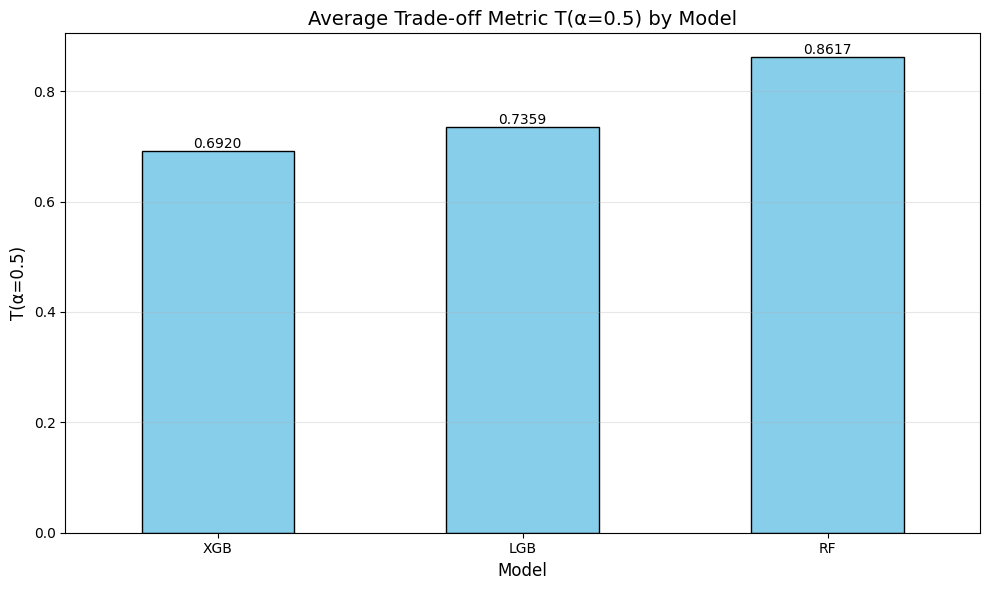

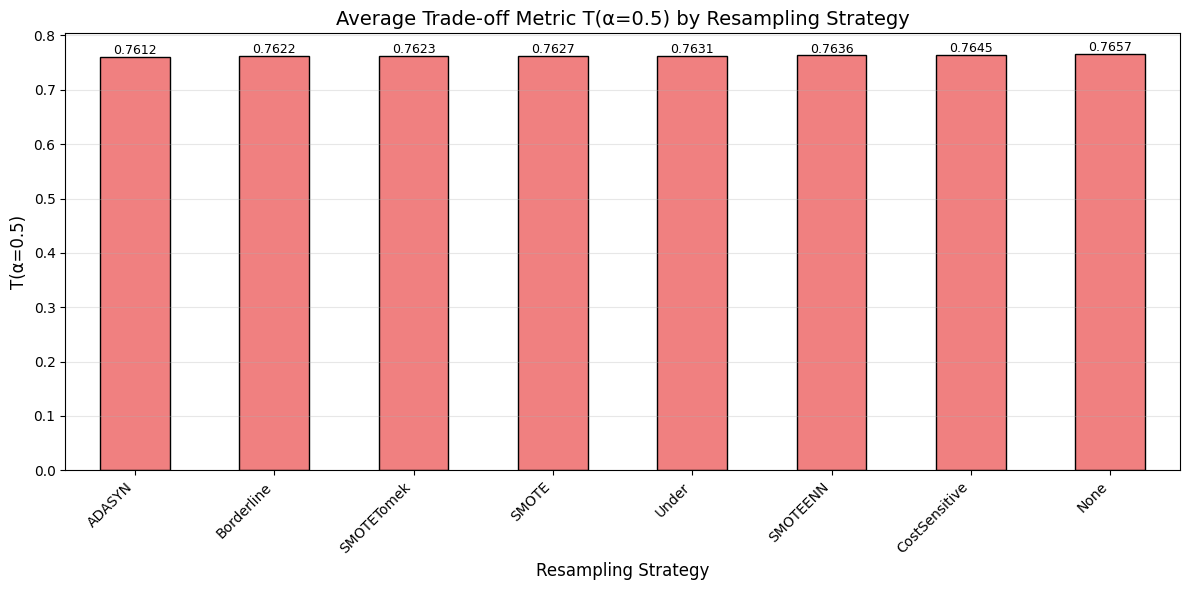

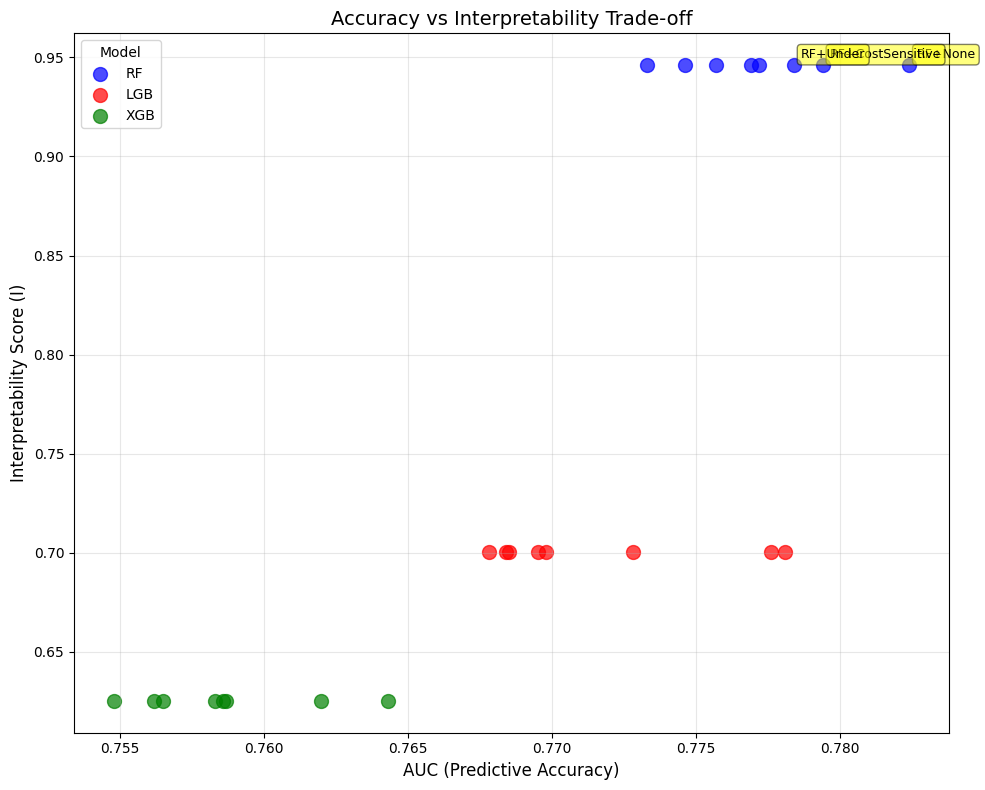

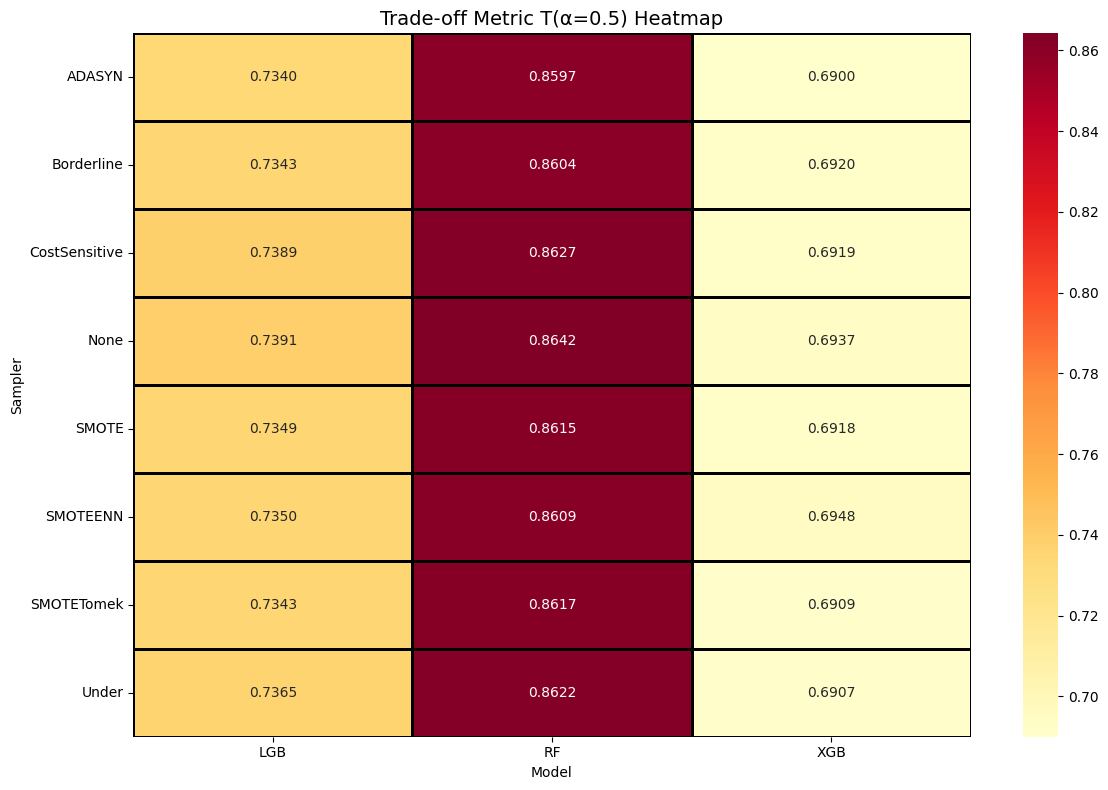

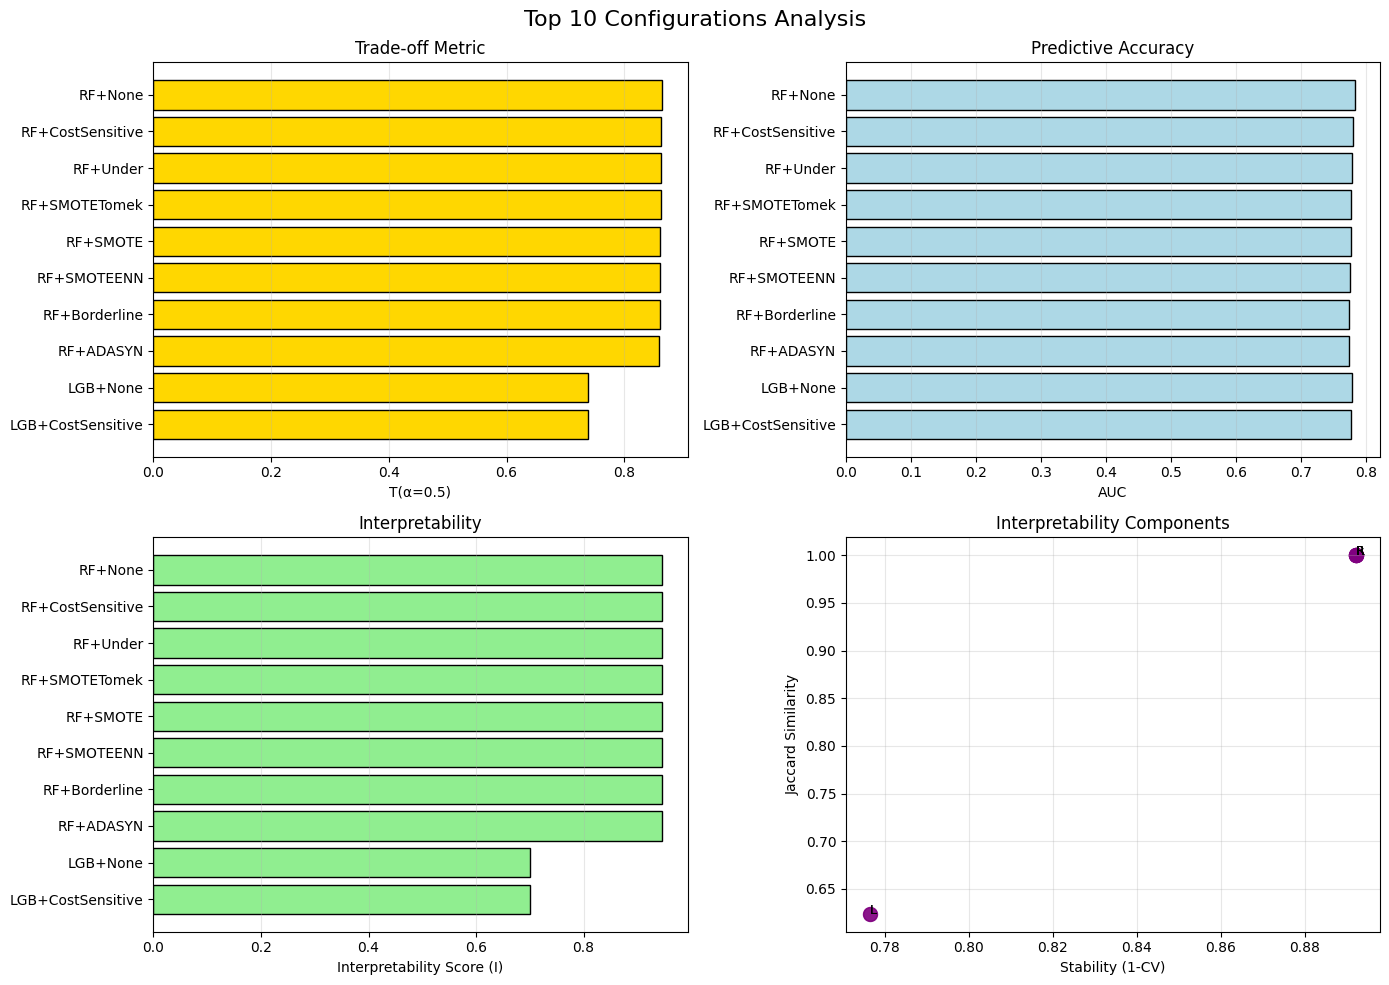

In [12]:
# ============================================================
# PART 8: Visualization
# ============================================================

def create_visualizations(metrics_df):
    """
    Create all visualizations for the thesis
    """
    # 1. Bar plot of average T(α=0.5) by model
    plt.figure(figsize=(10, 6))
    model_avg = metrics_df.groupby('Model')['T(α=0.5)'].mean().sort_values()
    model_avg.plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title('Average Trade-off Metric T(α=0.5) by Model', fontsize=14)
    plt.ylabel('T(α=0.5)', fontsize=12)
    plt.xlabel('Model', fontsize=12)
    plt.xticks(rotation=0)
    plt.grid(axis='y', alpha=0.3)

    # Add value labels on bars
    for i, v in enumerate(model_avg.values):
        plt.text(i, v + 0.005, f'{v:.4f}', ha='center', fontsize=10)

    plt.tight_layout()
    plt.show()

    # 2. Bar plot of average T(α=0.5) by sampler
    plt.figure(figsize=(12, 6))
    sampler_avg = metrics_df.groupby('Sampler')['T(α=0.5)'].mean().sort_values()
    sampler_avg.plot(kind='bar', color='lightcoral', edgecolor='black')
    plt.title('Average Trade-off Metric T(α=0.5) by Resampling Strategy', fontsize=14)
    plt.ylabel('T(α=0.5)', fontsize=12)
    plt.xlabel('Resampling Strategy', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', alpha=0.3)

    # Add value labels on bars
    for i, v in enumerate(sampler_avg.values):
        plt.text(i, v + 0.005, f'{v:.4f}', ha='center', fontsize=9)

    plt.tight_layout()
    plt.show()

    # 3. Scatter plot: AUC vs Interpretability
    plt.figure(figsize=(10, 8))

    # Color by model
    colors = {'RF': 'blue', 'XGB': 'green', 'LGB': 'red'}

    for model in metrics_df['Model'].unique():
        subset = metrics_df[metrics_df['Model'] == model]
        plt.scatter(subset['AUC'], subset['I'],
                   s=100, alpha=0.7, label=model, color=colors[model])

    plt.xlabel('AUC (Predictive Accuracy)', fontsize=12)
    plt.ylabel('Interpretability Score (I)', fontsize=12)
    plt.title('Accuracy vs Interpretability Trade-off', fontsize=14)
    plt.legend(title='Model')
    plt.grid(alpha=0.3)

    # Add annotations for top 3 configurations
    top3 = metrics_df.head(3)
    for idx, row in top3.iterrows():
        plt.annotate(f"{row['Model']}+{row['Sampler']}",
                    (row['AUC'], row['I']),
                    xytext=(5, 5), textcoords='offset points',
                    fontsize=9, bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.5))

    plt.tight_layout()
    plt.show()

    # 4. Heatmap of configurations
    plt.figure(figsize=(12, 8))

    # Create pivot table for heatmap
    pivot_data = metrics_df.pivot_table(values='T(α=0.5)',
                                       index='Sampler',
                                       columns='Model')

    sns.heatmap(pivot_data, annot=True, fmt='.4f', cmap='YlOrRd',
                linewidths=1, linecolor='black')
    plt.title('Trade-off Metric T(α=0.5) Heatmap', fontsize=14)
    plt.tight_layout()
    plt.show()

    # 5. Detailed comparison of top configurations
    top_n = 10
    top_configs = metrics_df.head(top_n)

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle(f'Top {top_n} Configurations Analysis', fontsize=16)

    # Subplot 1: T(α=0.5) values
    axes[0, 0].barh(range(len(top_configs)), top_configs['T(α=0.5)'].values,
                   color='gold', edgecolor='black')
    axes[0, 0].set_yticks(range(len(top_configs)))
    axes[0, 0].set_yticklabels([f"{row.Model}+{row.Sampler}" for _, row in top_configs.iterrows()])
    axes[0, 0].set_xlabel('T(α=0.5)')
    axes[0, 0].set_title('Trade-off Metric')
    axes[0, 0].invert_yaxis()
    axes[0, 0].grid(axis='x', alpha=0.3)

    # Subplot 2: AUC values
    axes[0, 1].barh(range(len(top_configs)), top_configs['AUC'].values,
                   color='lightblue', edgecolor='black')
    axes[0, 1].set_yticks(range(len(top_configs)))
    axes[0, 1].set_yticklabels([f"{row.Model}+{row.Sampler}" for _, row in top_configs.iterrows()])
    axes[0, 1].set_xlabel('AUC')
    axes[0, 1].set_title('Predictive Accuracy')
    axes[0, 1].invert_yaxis()
    axes[0, 1].grid(axis='x', alpha=0.3)

    # Subplot 3: Interpretability scores
    axes[1, 0].barh(range(len(top_configs)), top_configs['I'].values,
                   color='lightgreen', edgecolor='black')
    axes[1, 0].set_yticks(range(len(top_configs)))
    axes[1, 0].set_yticklabels([f"{row.Model}+{row.Sampler}" for _, row in top_configs.iterrows()])
    axes[1, 0].set_xlabel('Interpretability Score (I)')
    axes[1, 0].set_title('Interpretability')
    axes[1, 0].invert_yaxis()
    axes[1, 0].grid(axis='x', alpha=0.3)

    # Subplot 4: Stability vs Jaccard
    axes[1, 1].scatter(top_configs['Stability'], top_configs['Jaccard'],
                      s=100, alpha=0.7, color='purple')
    for idx, row in top_configs.iterrows():
        axes[1, 1].annotate(row['Model'][0],
                           (row['Stability'], row['Jaccard']),
                           fontsize=9)
    axes[1, 1].set_xlabel('Stability (1-CV)')
    axes[1, 1].set_ylabel('Jaccard Similarity')
    axes[1, 1].set_title('Interpretability Components')
    axes[1, 1].grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

# Create visualizations
print("\nCreating visualizations...")
create_visualizations(final_metrics_df)

Latex

In [13]:
# ============================================================
# PART 9: LaTeX Tables for Thesis
# ============================================================

def generate_latex_tables(metrics_df):
    """
    Generate LaTeX tables for thesis
    """
    # 1. Main results table (top 10 configurations)
    top_n = 10
    top_results = metrics_df.head(top_n).copy()

    # Format numbers for LaTeX
    latex_table = top_results[['Model', 'Sampler', 'AUC', 'CV', 'Stability', 'Jaccard', 'I', 'T(α=0.5)']].round(4)

    print("="*70)
    print("LATEX TABLE 1: Top 10 Configurations")
    print("="*70)
    print(latex_table.to_latex(
        index=False,
        caption=f"Top {top_n} configurations based on the trade-off metric $T(\\alpha=0.5)$",
        label="tab:top_configurations",
        float_format="%.4f"
    ))

    # 2. Summary by Model
    model_summary = metrics_df.groupby('Model').agg({
        'AUC': ['mean', 'std'],
        'I': ['mean', 'std'],
        'T(α=0.5)': ['mean', 'std']
    }).round(4)

    # Flatten multi-index columns
    model_summary.columns = ['_'.join(col).strip() for col in model_summary.columns.values]
    model_summary = model_summary.reset_index()

    print("\n" + "="*70)
    print("LATEX TABLE 2: Performance by Model")
    print("="*70)
    print(model_summary.to_latex(
        index=False,
        caption="Average performance metrics by model type",
        label="tab:model_summary",
        float_format="%.4f"
    ))

    # 3. Summary by Resampling Strategy
    sampler_summary = metrics_df.groupby('Sampler').agg({
        'AUC': ['mean', 'std'],
        'I': ['mean', 'std'],
        'T(α=0.5)': ['mean', 'std']
    }).round(4)

    # Flatten multi-index columns
    sampler_summary.columns = ['_'.join(col).strip() for col in sampler_summary.columns.values]
    sampler_summary = sampler_summary.reset_index()

    print("\n" + "="*70)
    print("LATEX TABLE 3: Performance by Resampling Strategy")
    print("="*70)
    print(sampler_summary.to_latex(
        index=False,
        caption="Average performance metrics by resampling strategy",
        label="tab:sampler_summary",
        float_format="%.4f"
    ))

    # 4. Correlation matrix
    correlation_matrix = metrics_df[['AUC', 'CV', 'Stability', 'Jaccard', 'I', 'T(α=0.5)']].corr().round(4)

    print("\n" + "="*70)
    print("LATEX TABLE 4: Correlation Matrix")
    print("="*70)
    print(correlation_matrix.to_latex(
        caption="Correlation matrix between different metrics",
        label="tab:correlation_matrix",
        float_format="%.4f"
    ))

    # 5. Statistical significance test (simplified)
    from scipy.stats import f_oneway

    print("\n" + "="*70)
    print("STATISTICAL ANALYSIS")
    print("="*70)

    # ANOVA test for model differences
    model_groups = [metrics_df[metrics_df['Model'] == model]['T(α=0.5)'].values
                   for model in metrics_df['Model'].unique()]
    f_stat, p_value = f_oneway(*model_groups)
    print(f"ANOVA test for model differences in T(α=0.5):")
    print(f"F-statistic = {f_stat:.4f}, p-value = {p_value:.4f}")

    if p_value < 0.05:
        print("Significant differences exist between models.")
    else:
        print("No significant differences between models.")

    # Best configuration analysis
    best_config = metrics_df.iloc[0]
    print(f"\nBest configuration:")
    print(f"Model: {best_config['Model']}, Sampler: {best_config['Sampler']}")
    print(f"AUC: {best_config['AUC']:.4f}, I: {best_config['I']:.4f}, T(α=0.5): {best_config['T(α=0.5)']:.4f}")

# Generate LaTeX tables
print("\nGenerating LaTeX tables for thesis...")
generate_latex_tables(final_metrics_df)


Generating LaTeX tables for thesis...
LATEX TABLE 1: Top 10 Configurations
\begin{table}
\caption{Top 10 configurations based on the trade-off metric $T(\alpha=0.5)$}
\label{tab:top_configurations}
\begin{tabular}{llrrrrrr}
\toprule
Model & Sampler & AUC & CV & Stability & Jaccard & I & T(α=0.5) \\
\midrule
RF & None & 0.7824 & 0.1078 & 0.8922 & 1.0000 & 0.9461 & 0.8642 \\
RF & CostSensitive & 0.7794 & 0.1078 & 0.8922 & 1.0000 & 0.9461 & 0.8627 \\
RF & Under & 0.7784 & 0.1078 & 0.8922 & 1.0000 & 0.9461 & 0.8622 \\
RF & SMOTETomek & 0.7772 & 0.1078 & 0.8922 & 1.0000 & 0.9461 & 0.8617 \\
RF & SMOTE & 0.7769 & 0.1078 & 0.8922 & 1.0000 & 0.9461 & 0.8615 \\
RF & SMOTEENN & 0.7757 & 0.1078 & 0.8922 & 1.0000 & 0.9461 & 0.8609 \\
RF & Borderline & 0.7746 & 0.1078 & 0.8922 & 1.0000 & 0.9461 & 0.8604 \\
RF & ADASYN & 0.7733 & 0.1078 & 0.8922 & 1.0000 & 0.9461 & 0.8597 \\
LGB & None & 0.7781 & 0.2235 & 0.7765 & 0.6239 & 0.7002 & 0.7391 \\
LGB & CostSensitive & 0.7776 & 0.2235 & 0.7765 & 0.6239 &

#Banzhaf and owen


COMPUTING ALL EXPLANATION METHODS
Computing explanations for 24 configurations...
Methods: ['SHAP', 'Banzhaf', 'Owen']

[1/24] LGB+ADASYN
  Run 1: Computing SHAP...
  Run 1: Computing Banzhaf...
  Computing Banzhaf for 20 instances, 5 samples per feature...
  Run 1: Computing Owen...
  Computing Owen with 5 groups...
  Run 2: Computing SHAP...
  Run 2: Computing Banzhaf...
  Computing Banzhaf for 20 instances, 5 samples per feature...
  Run 2: Computing Owen...
  Computing Owen with 5 groups...
  Run 3: Computing SHAP...
  Run 3: Computing Banzhaf...
  Computing Banzhaf for 20 instances, 5 samples per feature...
  Run 3: Computing Owen...
  Computing Owen with 5 groups...

[2/24] LGB+Borderline
  Run 1: Computing SHAP...
  Run 1: Computing Banzhaf...
  Computing Banzhaf for 20 instances, 5 samples per feature...
  Run 1: Computing Owen...
  Computing Owen with 5 groups...
  Run 2: Computing SHAP...
  Run 2: Computing Banzhaf...
  Computing Banzhaf for 20 instances, 5 samples per featu

,Model,Sampler,Method,AUC,CV,Stability,Jaccard,I,T(α=0.5)
0,RF,None,SHAP,0.7824,0.1144,0.8856,1.0000,0.9428,0.8626
1,RF,CostSensitive,SHAP,0.7794,0.1144,0.8856,1.0000,0.9428,0.8611
2,RF,Under,SHAP,0.7784,0.1144,0.8856,1.0000,0.9428,0.8606
3,RF,SMOTETomek,SHAP,0.7772,0.1144,0.8856,1.0000,0.9428,0.8600
4,RF,SMOTE,SHAP,0.7769,0.1144,0.8856,1.0000,0.9428,0.8599
5,RF,SMOTEENN,SHAP,0.7757,0.1144,0.8856,1.0000,0.9428,0.8592
6,RF,Borderline,SHAP,0.7746,0.1144,0.8856,1.0000,0.9428,0.8587
7,RF,ADASYN,SHAP,0.7733,0.1144,0.8856,1.0000,0.9428,0.8581
8,RF,None,Banzhaf,0.7824,0.1911,0.8089,0.7677,0.7883,0.7853
9,RF,SMOTETomek,Banzhaf,0.7772,0.1881,0.8119,0.6744,0.7432,0.7602



COMPARATIVE ANALYSIS BY EXPLANATION METHOD

1. Average Performance by Explanation Method:

SHAP:
  AUC: 0.7692 (±0.0086)
  Interpretability (I): 0.7851 (±0.1171)
  Trade-off T(α=0.5): 0.7771 (±0.0620)

Banzhaf:
  AUC: 0.7692 (±0.0086)
  Interpretability (I): 0.6515 (±0.0571)
  Trade-off T(α=0.5): 0.7104 (±0.0311)

Owen:
  AUC: 0.7692 (±0.0086)
  Interpretability (I): 0.5456 (±0.0488)
  Trade-off T(α=0.5): 0.6574 (±0.0271)

2. Best Configuration for Each Method:

SHAP:
  Model: RF, Sampler: None
  AUC: 0.7824, I: 0.9428, T(α=0.5): 0.8626

Banzhaf:
  Model: RF, Sampler: None
  AUC: 0.7824, I: 0.7883, T(α=0.5): 0.7853

Owen:
  Model: RF, Sampler: SMOTE
  AUC: 0.7769, I: 0.6335, T(α=0.5): 0.7052

3. Statistical Comparison:

AUC:
  ANOVA F-statistic: 0.0000, p-value: 1.0000
  -> No significant differences between methods
  SHAP vs Banzhaf: t=0.0000, p=1.0000
  SHAP vs Owen: t=0.0000, p=1.0000

I:
  ANOVA F-statistic: 53.6124, p-value: 0.0000
  -> Significant differences exist between metho

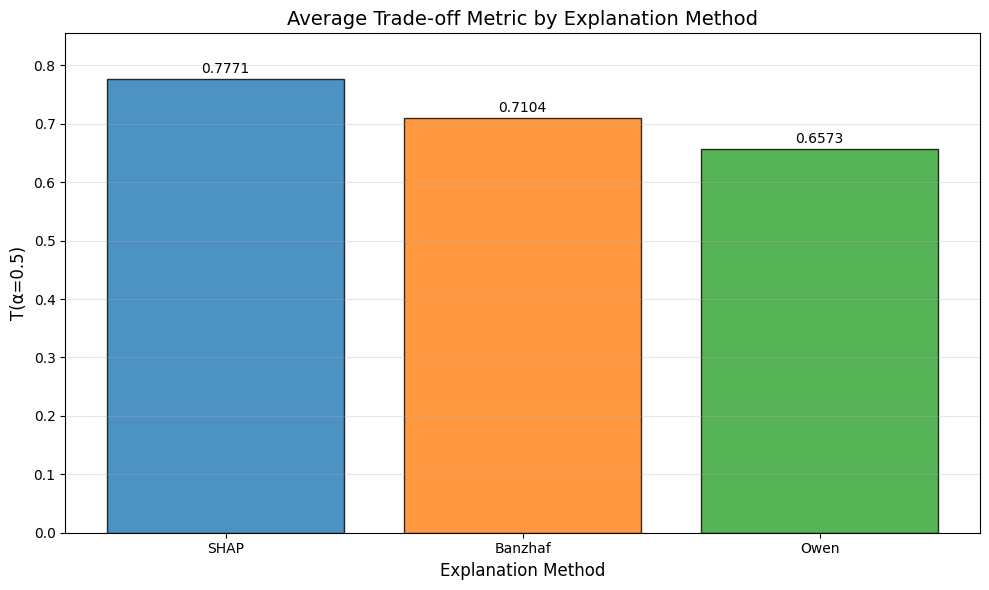

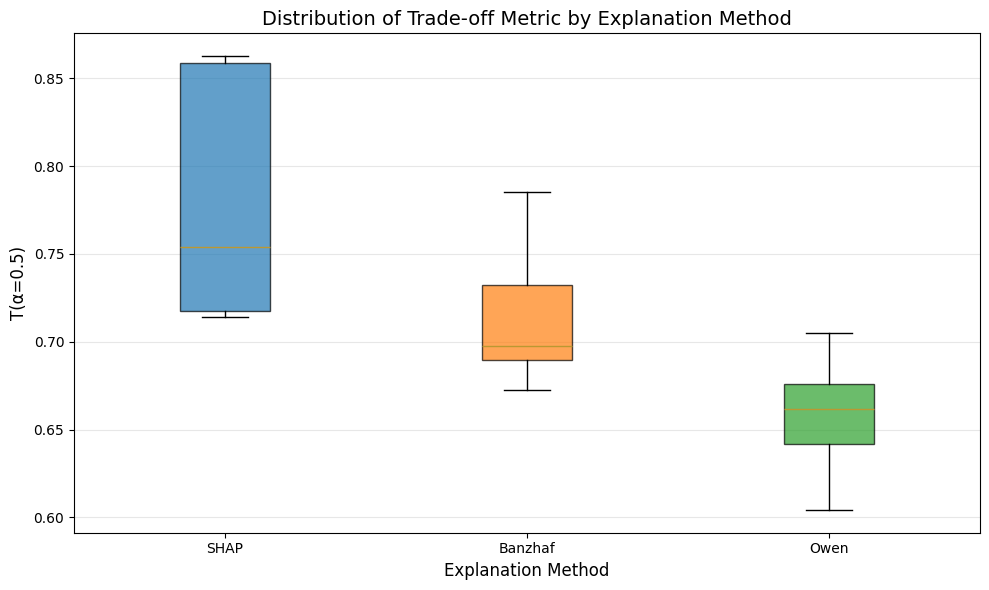

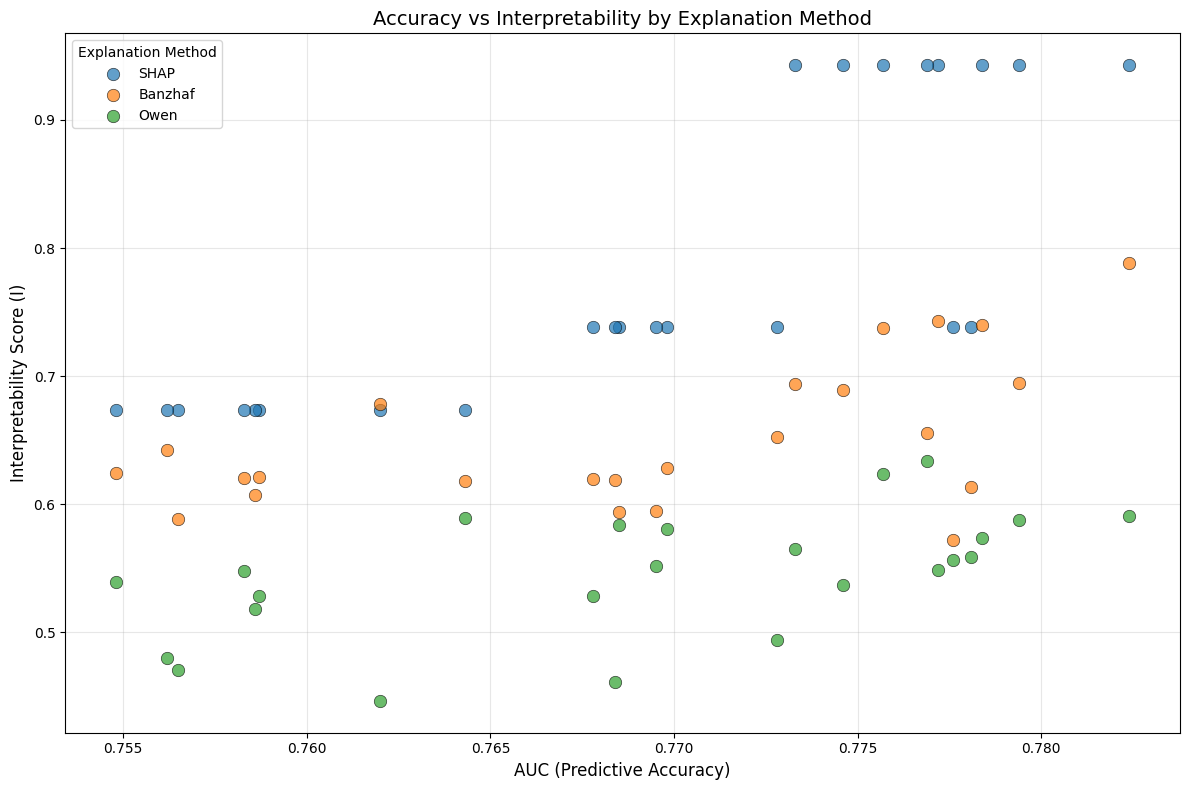

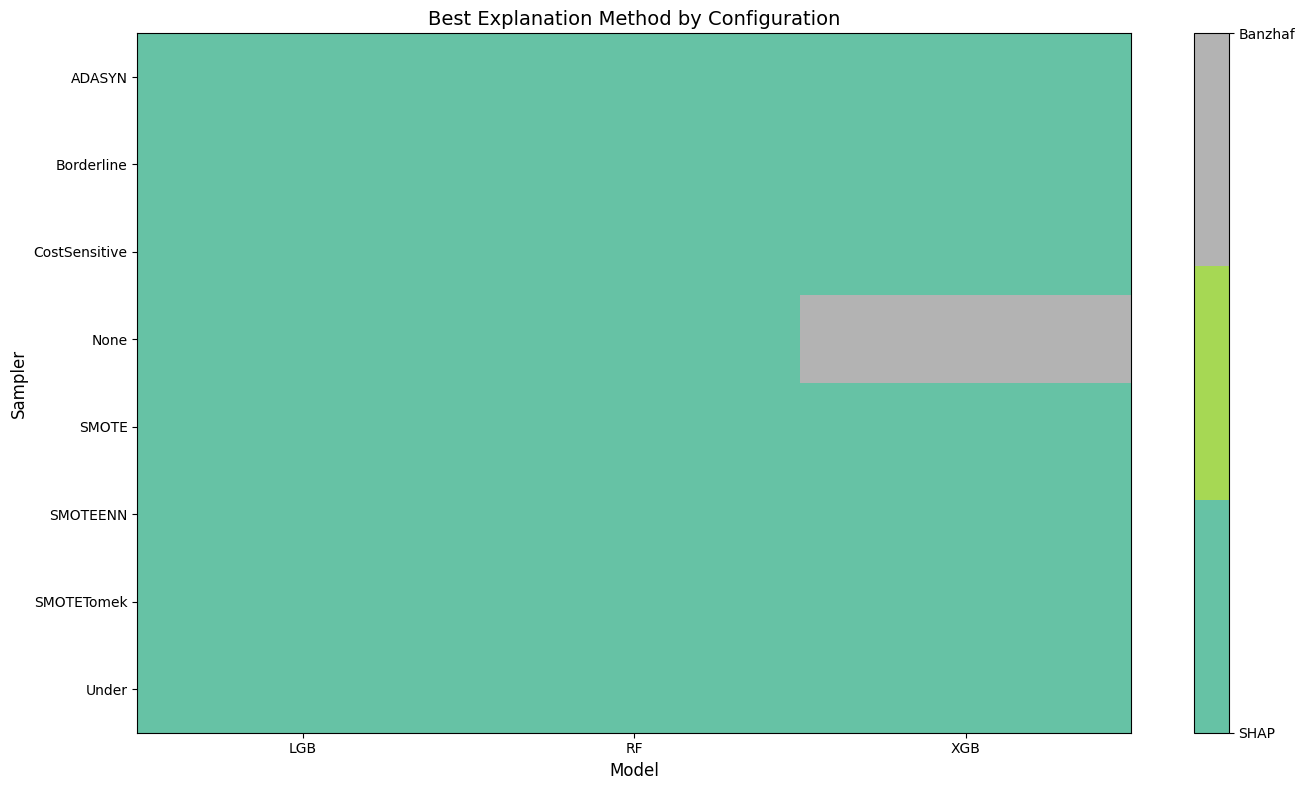


GENERATING LATEX TABLES FOR THESIS

LATEX TABLE 1: Top 5 Configurations for Each Method

\begin{table}[H]
\centering
\caption{Top 5 configurations using SHAP explanations}
\label{tab:top_shap}
\begin{tabular}{l l c c c c c}
\hline
Model & Sampler & AUC & I & CV & Jaccard & T(α=0.5) \\
\hline
RF & None & 0.7824 & 0.9428 & 0.1144 & 1.0000 & 0.8626 \\
RF & CostSensitive & 0.7794 & 0.9428 & 0.1144 & 1.0000 & 0.8611 \\
RF & Under & 0.7784 & 0.9428 & 0.1144 & 1.0000 & 0.8606 \\
RF & SMOTETomek & 0.7772 & 0.9428 & 0.1144 & 1.0000 & 0.8600 \\
RF & SMOTE & 0.7769 & 0.9428 & 0.1144 & 1.0000 & 0.8599 \\
\hline
\end{tabular}
\end{table}

\begin{table}[H]
\centering
\caption{Top 5 configurations using Banzhaf explanations}
\label{tab:top_banzhaf}
\begin{tabular}{l l c c c c c}
\hline
Model & Sampler & AUC & I & CV & Jaccard & T(α=0.5) \\
\hline
RF & None & 0.7824 & 0.7883 & 0.1911 & 0.7677 & 0.7853 \\
RF & SMOTETomek & 0.7772 & 0.7432 & 0.1881 & 0.6744 & 0.7602 \\
RF & Under & 0.7784 & 0.7402 & 0.

In [15]:
# ============================================================
# IMPLEMENTING BANZHAF AND OWEN VALUES
# ============================================================

import shap
from sklearn.inspection import permutation_importance
import itertools

# Feature groups for Owen value (credit-card dataset structure)
feature_groups = {
    "Demographic": ["SEX", "EDUCATION", "MARRIAGE", "AGE"],
    "CreditLimit": ["LIMIT_BAL"],
    "RepaymentStatus": ["PAY_0", "PAY_2", "PAY_3", "PAY_4", "PAY_5", "PAY_6"],
    "BillAmounts": ["BILL_AMT1", "BILL_AMT2", "BILL_AMT3",
                    "BILL_AMT4", "BILL_AMT5", "BILL_AMT6"],
    "PayAmounts": ["PAY_AMT1", "PAY_AMT2", "PAY_AMT3",
                   "PAY_AMT4", "PAY_AMT5", "PAY_AMT6"]
}

def compute_shap_values(pipe, X_sample, n_samples=100):
    """
    Compute SHAP values for a given pipeline
    """
    try:
        # Get classifier and preprocessed data
        clf = pipe.named_steps['clf']
        X_processed = pipe.named_steps['prep'].transform(X_sample)

        # Use TreeExplainer for tree-based models
        explainer = shap.TreeExplainer(clf)
        shap_values = explainer.shap_values(X_processed)

        # Handle different return formats
        if isinstance(shap_values, list):
            # Binary classification: shap_values[0] for class 0, shap_values[1] for class 1
            if len(shap_values) == 2:
                return shap_values[1]  # Use values for positive class
            else:
                return shap_values[0]
        else:
            return shap_values

    except Exception as e:
        print(f"SHAP failed: {e}. Using permutation importance as fallback.")

        # Fallback: permutation importance
        clf = pipe.named_steps['clf']
        X_processed = pipe.named_steps['prep'].transform(X_sample)

        # Use a subset for faster computation
        if len(X_sample) > 50:
            X_processed = X_processed[:50]

        result = permutation_importance(
            clf,
            X_processed,
            pipe.predict(X_sample[:len(X_processed)]),
            n_repeats=5,
            random_state=42,
            n_jobs=-1
        )

        # Create a matrix of importance values (broadcast to instances)
        importance_matrix = np.tile(result.importances_mean, (X_processed.shape[0], 1))
        return importance_matrix

def compute_banzhaf_values(pipe, X_sample, n_samples=100, max_instances=50):
    """
    Compute Banzhaf values using Monte Carlo approximation
    Banzhaf(f) = average marginal contribution over all coalitions
    """
    try:
        clf = pipe.named_steps['clf']
        preprocessor = pipe.named_steps['prep']
        X_processed = preprocessor.transform(X_sample)

        n_features = X_processed.shape[1]
        n_instances = min(max_instances, X_processed.shape[0])

        # Initialize Banzhaf matrix
        banzhaf_matrix = np.zeros((n_instances, n_features))

        # Get feature names for debugging
        feature_names = preprocessor.get_feature_names_out()

        print(f"  Computing Banzhaf for {n_instances} instances, {n_samples} samples per feature...")

        for i in range(n_instances):
            x_instance = X_processed[i:i+1]

            # Base prediction (all features present)
            base_pred = clf.predict_proba(x_instance)[0, 1]

            for f in range(n_features):
                contributions = []

                for _ in range(n_samples):
                    # Random coalition: each feature is in/out with 0.5 probability
                    coalition_mask = np.random.binomial(1, 0.5, n_features)

                    # Create instance with coalition
                    x_coalition = x_instance.copy() * coalition_mask

                    # Prediction with feature f OUT
                    coalition_without = coalition_mask.copy()
                    coalition_without[f] = 0
                    x_without = x_instance * coalition_without
                    pred_without = clf.predict_proba(x_without)[0, 1]

                    # Prediction with feature f IN
                    coalition_with = coalition_mask.copy()
                    coalition_with[f] = 1
                    x_with = x_instance * coalition_with
                    pred_with = clf.predict_proba(x_with)[0, 1]

                    # Marginal contribution
                    contribution = pred_with - pred_without
                    contributions.append(contribution)

                # Banzhaf value is average marginal contribution
                banzhaf_matrix[i, f] = np.mean(contributions)

        return banzhaf_matrix

    except Exception as e:
        print(f"Banzhaf computation failed: {e}")
        # Return SHAP as fallback
        return compute_shap_values(pipe, X_sample)

def compute_owen_values(pipe, X_sample, feature_groups, n_samples=50, max_instances=30):
    """
    Compute Owen values (group-aware Shapley)
    Features are partitioned into groups, and contributions are computed hierarchically
    """
    try:
        clf = pipe.named_steps['clf']
        preprocessor = pipe.named_steps['prep']
        X_processed = preprocessor.transform(X_sample)
        feature_names = preprocessor.get_feature_names_out()

        n_features = X_processed.shape[1]
        n_instances = min(max_instances, X_processed.shape[0])

        # Initialize Owen matrix
        owen_matrix = np.zeros((n_instances, n_features))

        # Create group mapping: feature index -> group name
        group_mapping = {}
        for group_name, features in feature_groups.items():
            # Find indices of these features in the processed feature space
            for feature in features:
                # Find feature in feature names (handles one-hot encoded features)
                for idx, name in enumerate(feature_names):
                    if feature in name:
                        group_mapping[idx] = group_name

        # For features not in any group, assign to "Other"
        for idx in range(n_features):
            if idx not in group_mapping:
                group_mapping[idx] = "Other"

        # Create reverse mapping: group name -> list of feature indices
        groups = {}
        for idx, group_name in group_mapping.items():
            if group_name not in groups:
                groups[group_name] = []
            groups[group_name].append(idx)

        print(f"  Computing Owen with {len(groups)} groups...")

        for i in range(n_instances):
            x_instance = X_processed[i:i+1]

            for f in range(n_features):
                contributions = []
                feature_group = group_mapping[f]

                for _ in range(n_samples):
                    # Step 1: Randomly select which GROUPS are active
                    group_selection = {}
                    for group_name in groups.keys():
                        group_selection[group_name] = np.random.choice([0, 1])

                    # Step 2: Within the feature's group, randomly select which FEATURES are active
                    mask = np.zeros(n_features)

                    for group_name, feature_indices in groups.items():
                        if group_selection[group_name] == 1:
                            if group_name == feature_group:
                                # For the feature's group, random subset including possibly f
                                for idx in feature_indices:
                                    mask[idx] = np.random.choice([0, 1])
                            else:
                                # For other groups, all features are active
                                mask[feature_indices] = 1

                    # Create mask without feature f
                    mask_without = mask.copy()
                    mask_without[f] = 0

                    # Compute predictions
                    x_without = x_instance * mask_without
                    pred_without = clf.predict_proba(x_without)[0, 1]

                    x_with = x_instance * mask
                    pred_with = clf.predict_proba(x_with)[0, 1]

                    # Marginal contribution
                    contribution = pred_with - pred_without
                    contributions.append(contribution)

                # Owen value is average marginal contribution
                owen_matrix[i, f] = np.mean(contributions)

        return owen_matrix

    except Exception as e:
        print(f"Owen computation failed: {e}")
        # Return SHAP as fallback
        return compute_shap_values(pipe, X_sample)

def compute_all_explanations(results_df, methods=['SHAP', 'Banzhaf', 'Owen'],
                            n_instances=50, n_samples=100):
    """
    Compute all explanation methods for all configurations
    """
    explanations = {}

    # Group by model and sampler
    grouped = results_df.groupby(['model', 'sampler'])
    total_configs = len(grouped)

    print(f"Computing explanations for {total_configs} configurations...")
    print(f"Methods: {methods}")

    for idx, ((model_name, sampler_name), group) in enumerate(grouped, 1):
        print(f"\n[{idx}/{total_configs}] {model_name}+{sampler_name}")

        # Initialize dictionaries for this configuration
        config_explanations = {method: [] for method in methods}

        for run_idx, (_, row) in enumerate(group.iterrows(), 1):
            pipe = row['pipeline']
            X_test = row['X_test']

            # Sample instances for explanation
            if len(X_test) > n_instances:
                X_sample = X_test.sample(n=n_instances, random_state=run_idx*42)
            else:
                X_sample = X_test

            # Compute each explanation method
            if 'SHAP' in methods:
                print(f"  Run {run_idx}: Computing SHAP...")
                shap_vals = compute_shap_values(pipe, X_sample)
                config_explanations['SHAP'].append(shap_vals)

            if 'Banzhaf' in methods:
                print(f"  Run {run_idx}: Computing Banzhaf...")
                banzhaf_vals = compute_banzhaf_values(pipe, X_sample,
                                                    n_samples=n_samples//10,  # Fewer samples for speed
                                                    max_instances=min(20, n_instances))
                config_explanations['Banzhaf'].append(banzhaf_vals)

            if 'Owen' in methods:
                print(f"  Run {run_idx}: Computing Owen...")
                owen_vals = compute_owen_values(pipe, X_sample, feature_groups,
                                               n_samples=n_samples//20,  # Even fewer for speed
                                               max_instances=min(15, n_instances))
                config_explanations['Owen'].append(owen_vals)

        # Store all methods for this configuration
        for method in methods:
            explanations[(model_name, sampler_name, method)] = config_explanations[method]

    return explanations

# Compute all explanation methods
print("\n" + "="*70)
print("COMPUTING ALL EXPLANATION METHODS")
print("="*70)

all_explanations = compute_all_explanations(
    results_df,
    methods=['SHAP', 'Banzhaf', 'Owen'],
    n_instances=30,  # Reduced for speed
    n_samples=50     # Reduced for speed
)

print(f"\nTotal explanation sets computed: {len(all_explanations)}")

# ============================================================
# UPDATED METRICS COMPUTATION FOR ALL METHODS
# ============================================================

def compute_all_metrics_all_methods(results_df, explanations_dict,
                                   beta=0.5, alpha=0.5, top_k=10):
    """
    Compute all metrics for all configurations and all explanation methods
    """
    records = []

    # Group by model and sampler
    grouped = results_df.groupby(['model', 'sampler'])
    total_configs = len(grouped)

    print(f"\nProcessing {total_configs} configurations across 3 explanation methods...")

    for idx, ((model_name, sampler_name), group) in enumerate(grouped, 1):
        # Get AUC (average across runs)
        auc_mean = group['auc'].mean()

        # Process each explanation method
        for method in ['SHAP', 'Banzhaf', 'Owen']:
            config_key = (model_name, sampler_name, method)

            if config_key in explanations_dict:
                explanation_list = explanations_dict[config_key]

                # Debug info
                if idx == 1 and method == 'SHAP':
                    print(f"\nSample debug - First config, {method}:")
                    print(f"  Number of runs: {len(explanation_list)}")
                    if explanation_list:
                        print(f"  Shape of first run: {explanation_list[0].shape}")
                        print(f"  Type: {type(explanation_list[0])}")

                # Compute stability metrics
                stability_metrics = compute_stability_metrics(explanation_list)
                cv = stability_metrics['cv']
                stability = stability_metrics['stability']

                # Compute Jaccard similarity
                jaccard = compute_jaccard_similarity(explanation_list, top_k=top_k)

                # Compute interpretability score
                I = compute_interpretability_score(cv, jaccard, beta=beta)

                # Compute trade-off metric
                T = compute_tradeoff_metric(auc_mean, I, alpha=alpha)

                # Store results
                records.append({
                    'Model': model_name,
                    'Sampler': sampler_name,
                    'Method': method,
                    'AUC': round(auc_mean, 4),
                    'CV': round(cv, 4),
                    'Stability': round(stability, 4),
                    'Jaccard': round(jaccard, 4),
                    'I': round(I, 4),
                    'T(α=0.5)': round(T, 4)
                })
            else:
                print(f"Warning: No {method} explanations found for {model_name}+{sampler_name}")

        # Progress update
        if idx % 3 == 0:
            print(f"  Processed {idx}/{total_configs} configurations...")

    # Create DataFrame
    metrics_df = pd.DataFrame(records)

    # Sort by trade-off metric
    metrics_df = metrics_df.sort_values('T(α=0.5)', ascending=False).reset_index(drop=True)

    return metrics_df

# Compute metrics for all methods
print("\n" + "="*70)
print("COMPUTING METRICS FOR ALL EXPLANATION METHODS")
print("="*70)

final_metrics_all_methods = compute_all_metrics_all_methods(
    results_df,
    all_explanations,
    beta=0.5,
    alpha=0.5,
    top_k=10
)

print("\n" + "="*70)
print("FINAL RESULTS - ALL METHODS (Top 20 configurations):")
print("="*70)
display(final_metrics_all_methods.head(20))

# ============================================================
# ANALYSIS BY EXPLANATION METHOD
# ============================================================

print("\n" + "="*70)
print("COMPARATIVE ANALYSIS BY EXPLANATION METHOD")
print("="*70)

# 1. Summary by Explanation Method
print("\n1. Average Performance by Explanation Method:")
method_summary = final_metrics_all_methods.groupby('Method').agg({
    'AUC': ['mean', 'std', 'min', 'max'],
    'I': ['mean', 'std', 'min', 'max'],
    'T(α=0.5)': ['mean', 'std', 'min', 'max']
}).round(4)

# Display in a readable format
for method in ['SHAP', 'Banzhaf', 'Owen']:
    if method in method_summary.index:
        data = method_summary.loc[method]
        print(f"\n{method}:")
        print(f"  AUC: {data[('AUC', 'mean')]:.4f} (±{data[('AUC', 'std')]:.4f})")
        print(f"  Interpretability (I): {data[('I', 'mean')]:.4f} (±{data[('I', 'std')]:.4f})")
        print(f"  Trade-off T(α=0.5): {data[('T(α=0.5)', 'mean')]:.4f} (±{data[('T(α=0.5)', 'std')]:.4f})")

# 2. Best configuration for each method
print("\n2. Best Configuration for Each Method:")
for method in ['SHAP', 'Banzhaf', 'Owen']:
    method_df = final_metrics_all_methods[final_metrics_all_methods['Method'] == method]
    if not method_df.empty:
        best_config = method_df.iloc[0]
        print(f"\n{method}:")
        print(f"  Model: {best_config['Model']}, Sampler: {best_config['Sampler']}")
        print(f"  AUC: {best_config['AUC']:.4f}, I: {best_config['I']:.4f}, T(α=0.5): {best_config['T(α=0.5)']:.4f}")

# 3. Statistical comparison
print("\n3. Statistical Comparison:")
from scipy.stats import f_oneway, ttest_ind

for metric in ['AUC', 'I', 'T(α=0.5)']:
    print(f"\n{metric}:")

    # Extract values for each method
    shap_vals = final_metrics_all_methods[final_metrics_all_methods['Method'] == 'SHAP'][metric].values
    banzhaf_vals = final_metrics_all_methods[final_metrics_all_methods['Method'] == 'Banzhaf'][metric].values
    owen_vals = final_metrics_all_methods[final_metrics_all_methods['Method'] == 'Owen'][metric].values

    # ANOVA test
    if len(shap_vals) > 0 and len(banzhaf_vals) > 0 and len(owen_vals) > 0:
        f_stat, p_value = f_oneway(shap_vals, banzhaf_vals, owen_vals)
        print(f"  ANOVA F-statistic: {f_stat:.4f}, p-value: {p_value:.4f}")

        if p_value < 0.05:
            print(f"  -> Significant differences exist between methods")
        else:
            print(f"  -> No significant differences between methods")

        # Pairwise t-tests
        if len(shap_vals) > 1 and len(banzhaf_vals) > 1:
            t_stat_shap_banzhaf, p_shap_banzhaf = ttest_ind(shap_vals, banzhaf_vals)
            print(f"  SHAP vs Banzhaf: t={t_stat_shap_banzhaf:.4f}, p={p_shap_banzhaf:.4f}")

        if len(shap_vals) > 1 and len(owen_vals) > 1:
            t_stat_shap_owen, p_shap_owen = ttest_ind(shap_vals, owen_vals)
            print(f"  SHAP vs Owen: t={t_stat_shap_owen:.4f}, p={p_shap_owen:.4f}")

# 4. Correlation between different explanation methods
print("\n4. Correlation Between Methods (for T(α=0.5)):")

# Create pivot table
pivot_data = final_metrics_all_methods.pivot_table(
    values='T(α=0.5)',
    index=['Model', 'Sampler'],
    columns='Method'
)

# Calculate correlations
if not pivot_data.empty and 'SHAP' in pivot_data.columns and 'Banzhaf' in pivot_data.columns:
    corr_shap_banzhaf = pivot_data['SHAP'].corr(pivot_data['Banzhaf'])
    print(f"  SHAP vs Banzhaf correlation: {corr_shap_banzhaf:.4f}")

if not pivot_data.empty and 'SHAP' in pivot_data.columns and 'Owen' in pivot_data.columns:
    corr_shap_owen = pivot_data['SHAP'].corr(pivot_data['Owen'])
    print(f"  SHAP vs Owen correlation: {corr_shap_owen:.4f}")

# ============================================================
# VISUALIZATION FOR ALL METHODS
# ============================================================

def create_comparison_visualizations(metrics_df):
    """
    Create visualizations comparing all explanation methods
    """
    # 1. Bar plot: Average T(α=0.5) by explanation method
    plt.figure(figsize=(10, 6))
    method_avg = metrics_df.groupby('Method')['T(α=0.5)'].mean().reindex(['SHAP', 'Banzhaf', 'Owen'])

    colors = {'SHAP': '#1f77b4', 'Banzhaf': '#ff7f0e', 'Owen': '#2ca02c'}
    bar_colors = [colors[method] for method in method_avg.index]

    bars = plt.bar(method_avg.index, method_avg.values,
                   color=bar_colors, edgecolor='black', alpha=0.8)

    plt.title('Average Trade-off Metric by Explanation Method', fontsize=14)
    plt.ylabel('T(α=0.5)', fontsize=12)
    plt.xlabel('Explanation Method', fontsize=12)
    plt.ylim(0, max(method_avg.values) * 1.1)

    # Add value labels
    for bar, value in zip(bars, method_avg.values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                f'{value:.4f}', ha='center', va='bottom', fontsize=10)

    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

    # 2. Box plot: Distribution of T(α=0.5) by method
    plt.figure(figsize=(10, 6))
    box_data = [metrics_df[metrics_df['Method'] == method]['T(α=0.5)'].values
                for method in ['SHAP', 'Banzhaf', 'Owen']]

    box = plt.boxplot(box_data, labels=['SHAP', 'Banzhaf', 'Owen'],
                      patch_artist=True)

    # Color the boxes
    for patch, color in zip(box['boxes'], ['#1f77b4', '#ff7f0e', '#2ca02c']):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)

    plt.title('Distribution of Trade-off Metric by Explanation Method', fontsize=14)
    plt.ylabel('T(α=0.5)', fontsize=12)
    plt.xlabel('Explanation Method', fontsize=12)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

    # 3. Scatter plot: AUC vs Interpretability, colored by method
    plt.figure(figsize=(12, 8))

    for method, color in colors.items():
        subset = metrics_df[metrics_df['Method'] == method]
        if not subset.empty:
            plt.scatter(subset['AUC'], subset['I'],
                       s=80, alpha=0.7, label=method, color=color,
                       edgecolors='black', linewidth=0.5)

    plt.xlabel('AUC (Predictive Accuracy)', fontsize=12)
    plt.ylabel('Interpretability Score (I)', fontsize=12)
    plt.title('Accuracy vs Interpretability by Explanation Method', fontsize=14)
    plt.legend(title='Explanation Method')
    plt.grid(alpha=0.3)

    # Add Pareto frontier
    # Find non-dominated points (for visualization)
    points = metrics_df[['AUC', 'I']].values
    pareto_mask = np.ones(len(points), dtype=bool)

    for i, point_i in enumerate(points):
        for j, point_j in enumerate(points):
            if i != j and all(point_j >= point_i) and any(point_j > point_i):
                pareto_mask[i] = False
                break

    pareto_points = points[pareto_mask]
    if len(pareto_points) > 1:
        pareto_points = pareto_points[np.argsort(pareto_points[:, 0])]
        plt.plot(pareto_points[:, 0], pareto_points[:, 1],
                'r--', alpha=0.5, label='Pareto Frontier')

    plt.tight_layout()
    plt.show()

    # 4. Heatmap: Best method for each model+sampler combination
    plt.figure(figsize=(14, 8))

    # Create pivot table
    pivot_best = metrics_df.pivot_table(
        values='T(α=0.5)',
        index=['Model', 'Sampler'],
        columns='Method'
    )

    # Find best method for each configuration
    best_methods = pivot_best.idxmax(axis=1)
    best_values = pivot_best.max(axis=1)

    # Create matrix for heatmap
    models = sorted(metrics_df['Model'].unique())
    samplers = sorted(metrics_df['Sampler'].unique())

    heatmap_data = np.zeros((len(samplers), len(models)))
    method_map = {'SHAP': 0, 'Banzhaf': 1, 'Owen': 2}

    for i, sampler in enumerate(samplers):
        for j, model in enumerate(models):
            key = (model, sampler)
            if key in best_methods:
                heatmap_data[i, j] = method_map.get(best_methods[key], -1)

    # Plot heatmap
    cmap = plt.cm.get_cmap('Set2', 3)
    im = plt.imshow(heatmap_data, cmap=cmap, aspect='auto')

    plt.yticks(range(len(samplers)), samplers)
    plt.xticks(range(len(models)), models)
    plt.xlabel('Model', fontsize=12)
    plt.ylabel('Sampler', fontsize=12)
    plt.title('Best Explanation Method by Configuration', fontsize=14)

    # Add colorbar
    cbar = plt.colorbar(im, ticks=[0, 1, 2])
    cbar.ax.set_yticklabels(['SHAP', 'Banzhaf', 'Owen'])

    plt.tight_layout()
    plt.show()

# Create visualizations
print("\n" + "="*70)
print("CREATING COMPARATIVE VISUALIZATIONS")
print("="*70)

create_comparison_visualizations(final_metrics_all_methods)

# ============================================================
# LATEX TABLES FOR THESIS
# ============================================================

def generate_comparison_latex_tables(metrics_df):
    """
    Generate LaTeX tables comparing all explanation methods
    """
    # 1. Top configurations for each method
    print("\n" + "="*70)
    print("LATEX TABLE 1: Top 5 Configurations for Each Method")
    print("="*70)

    for method in ['SHAP', 'Banzhaf', 'Owen']:
        method_df = metrics_df[metrics_df['Method'] == method].head(5)

        if not method_df.empty:
            print(f"\n\\begin{{table}}[H]")
            print(f"\\centering")
            print(f"\\caption{{Top 5 configurations using {method} explanations}}")
            print(f"\\label{{tab:top_{method.lower()}}}")
            print(f"\\begin{{tabular}}{{l l c c c c c}}")
            print(f"\\hline")
            print(f"Model & Sampler & AUC & I & CV & Jaccard & T(α=0.5) \\\\")
            print(f"\\hline")

            for _, row in method_df.iterrows():
                print(f"{row['Model']} & {row['Sampler']} & {row['AUC']:.4f} & {row['I']:.4f} & "
                      f"{row['CV']:.4f} & {row['Jaccard']:.4f} & {row['T(α=0.5)']:.4f} \\\\")

            print(f"\\hline")
            print(f"\\end{{tabular}}")
            print(f"\\end{{table}}")

    # 2. Summary table comparing methods
    print("\n" + "="*70)
    print("LATEX TABLE 2: Comparison of Explanation Methods")
    print("="*70)

    summary = metrics_df.groupby('Method').agg({
        'AUC': ['mean', 'std'],
        'I': ['mean', 'std'],
        'T(α=0.5)': ['mean', 'std']
    }).round(4)

    # Format for LaTeX
    print("\\begin{table}[H]")
    print("\\centering")
    print("\\caption{Comparison of explanation methods across all configurations}")
    print("\\label{tab:method_comparison}")
    print("\\begin{tabular}{l c c c c c c}")
    print("\\hline")
    print("Method & \\multicolumn{2}{c}{AUC} & \\multicolumn{2}{c}{I} & \\multicolumn{2}{c}{T(α=0.5)} \\\\")
    print("\\cline{2-3} \\cline{4-5} \\cline{6-7}")
    print(" & Mean & Std & Mean & Std & Mean & Std \\\\")
    print("\\hline")

    for method in ['SHAP', 'Banzhaf', 'Owen']:
        if method in summary.index:
            data = summary.loc[method]
            print(f"{method} & {data[('AUC', 'mean')]:.4f} & {data[('AUC', 'std')]:.4f} & "
                  f"{data[('I', 'mean')]:.4f} & {data[('I', 'std')]:.4f} & "
                  f"{data[('T(α=0.5)', 'mean')]:.4f} & {data[('T(α=0.5)', 'std')]:.4f} \\\\")

    print("\\hline")
    print("\\end{tabular}")
    print("\\end{table}")

    # 3. Statistical significance table
    print("\n" + "="*70)
    print("LATEX TABLE 3: Statistical Significance Tests")
    print("="*70)

    print("\\begin{table}[H]")
    print("\\centering")
    print("\\caption{Statistical significance tests between explanation methods}")
    print("\\label{tab:statistical_tests}")
    print("\\begin{tabular}{l c c c}")
    print("\\hline")
    print("Comparison & t-statistic & p-value & Significant? \\\\")
    print("\\hline")

    # Perform t-tests
    from scipy.stats import ttest_ind

    methods = ['SHAP', 'Banzhaf', 'Owen']
    method_data = {}

    for method in methods:
        method_data[method] = metrics_df[metrics_df['Method'] == method]['T(α=0.5)'].values

    # Pairwise comparisons
    comparisons = [('SHAP', 'Banzhaf'), ('SHAP', 'Owen'), ('Banzhaf', 'Owen')]

    for method1, method2 in comparisons:
        if len(method_data[method1]) > 1 and len(method_data[method2]) > 1:
            t_stat, p_value = ttest_ind(method_data[method1], method_data[method2])
            significant = "Yes" if p_value < 0.05 else "No"
            print(f"{method1} vs {method2} & {t_stat:.4f} & {p_value:.4f} & {significant} \\\\")

    print("\\hline")
    print("\\end{tabular}")
    print("\\end{table}")

# Generate LaTeX tables
print("\n" + "="*70)
print("GENERATING LATEX TABLES FOR THESIS")
print("="*70)

generate_comparison_latex_tables(final_metrics_all_methods)


